# Analysis of the global spice trade 2007-2017

We are going to explore and anlyze a [UN dataset covering a decade of the global spice trade](http://data.un.org/Data.aspx?d=ComTrade&f=_l1Code%3a10).  The UN publishes annual data of global exports and imports of a wide variety of commodities as part of their "Commodity Trade Statistics Database" which can be accessed through the more general [UN Datamart](http://data.un.org/Explorer.aspx).  While the database has entries back to 1992, the Datamart limits each data download to 100,000 records and the 2007-2017 timeframe is the longest period which fits inside the record size limit.  The complete dataset could certainly be saved piecemeal and reconstituted via pandas, however, for our first analysis this 11 year timeframe be sufficent to glean some interesting details.

This dataset piques my interest because it contains trade data on coffee (my lifeblood as a father of two kids under 2) and vanilla, which has been [getting](https://www.tasteofhome.com/article/vanilla-prices-are-skyrocketing/) extremely [expensive](https://www.ft.com/content/02042190-65bc-11e8-90c2-9563a0613e56) recently.

We're going to assume that the UN has a complete and accurate accounting of the global spice trade.  It definitely seems that way.  This dataset contains columns for country/area, year, commodity, trade flow, trade in US dollars, and trade in kilograms.  Let's take an initial look at what is really here before we ask and answer some analytical questions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
trade = pd.read_csv('UN_GlobalSpiceTrade.csv')

In [3]:
trade.head(10)

,Country or Area,Year,Commodity,Flow,Trade (USD),Weight (kg),Quantity Name,Quantity
0,Afghanistan,2016,"Tea, green (unfermented) in packages < 3 kg",Import,44819548.0,28093001.0,Weight in kilograms,28093001.0
1,Afghanistan,2016,"Tea, black (fermented or partly) in packages <...",Import,44851687.0,23509706.0,Weight in kilograms,23509706.0
2,Afghanistan,2016,Mate,Export,2436431.0,2204973.0,Weight in kilograms,2204973.0
3,Afghanistan,2016,Coriander seeds,Export,458385.0,223854.0,Weight in kilograms,223854.0
4,Afghanistan,2016,Cumin seeds,Export,24003685.0,5924356.0,Weight in kilograms,5924356.0
5,Afghanistan,2016,Saffron,Export,3868724.0,2402.0,Weight in kilograms,2402.0
6,Afghanistan,2016,Spices nes,Export,60363.0,3982.0,Weight in kilograms,3982.0
7,Afghanistan,2015,"Tea, green (unfermented) in packages < 3 kg",Import,51338067.0,32447158.0,Weight in kilograms,32447158.0
8,Afghanistan,2015,"Tea, black (fermented or partly) in packages <...",Import,77686841.0,39914377.0,Weight in kilograms,39914377.0
9,Afghanistan,2015,Mate,Export,10561370.0,9333753.0,Weight in kilograms,9333753.0


In [4]:
# Rename the columns to make them easier to deal with later
trade.columns = ['country', 'year', 'commodity', 'flow', 'USD', 'kg', 'quant_name', 'quant']

In [5]:
trade.describe()

,year,USD,kg,quant
count,84123.000000,8.412300e+04,8.364300e+04,8.384600e+04
mean,2011.807128,1.238754e+07,3.713998e+06,3.713736e+06
std,3.109353,1.488183e+08,5.431667e+07,5.427358e+07
min,2007.000000,1.370904e-01,0.000000e+00,0.000000e+00
25%,2009.000000,8.362500e+03,1.518000e+03,1.511250e+03
50%,2012.000000,9.910400e+04,2.261213e+04,2.255700e+04
75%,2014.000000,1.050370e+06,2.559645e+05,2.555408e+05
max,2017.000000,1.179541e+10,5.693435e+09,5.693435e+09


In [6]:
trade['country'].nunique()

192

In [7]:
trade['commodity'].nunique()

33

In [8]:
trade['commodity'].value_counts().sort_index()

Anise or badian seeds                                   2660
Capsicum or Pimenta, dried, crushed or ground           3208
Caraway seeds                                           1013
Cardamoms                                               2442
Cinnamon and cinnamon-tree flowers crushed or ground    2775
Cinnamon and cinnamon-tree flowers whole                2773
Cloves (whole fruit, cloves and stems)                  2717
Coffee husks and skins                                   171
Coffee substitutes containing coffee                    2870
Coffee, not roasted, decaffeinated                      2584
Coffee, not roasted, not decaffeinated                  3290
Coffee, roasted, decaffeinated                          3089
Coffee, roasted, not decaffeinated                      3451
Coriander seeds                                         2698
Cumin seeds                                             2682
Curry                                                    316
Fennel seeds, juniper be



## Initial data exploration

We see that we have ~84,000 records organized by country, year, commodity type, and trade flow.  There are 192 countries and 33 different spices.  

Coffee, tea, pepper, and cinnamon all have multiple commodity type listings.  There are also two catch-all commodity types, 'Mixtures of spices' and 'Spices nes', which is a category for any spice not already listed individually.  Interestingly, salt isn't here -- presumably because it's not a plant product the UN has listed it in a different database.

The trade values, both in dollars and kilograms, have a huge range.  Specifically, the minimum trade in dollars is \$0.13 (13 cents!?) and the maximum is approximately 12 billion dollars.  We'll have to keep this enormous range in mind when we plot the data.

Before we ask any questions about the data, let's first do some cleaning.  We'll group all those coffee and tea categories to make a cleaner dataset and we'll also create separate dataframes for the export and import records.

In [9]:
# Grouping all the tea and coffee sub-commodity types into a 2 seperate major categories

# Locating all rows with a Tea commodity type
tea = trade.loc[trade.iloc[:,2].str.contains(r'^Tea')]
grouped_tea = pd.DataFrame(tea.groupby(['country', 'year', 'flow']
                                      )['USD', 'kg', 'quant'].sum().reset_index())

# Adding the commodity name and quant_name columns back to the DataFrame
grouped_tea['commodity'] = 'Tea'
grouped_tea['quant_name'] = 'Weight in kilograms'

# Reordering the columns to match the original DataFrame layout
grouped_tea = grouped_tea[['country', 'year', 'commodity', 'flow', 'USD', 'kg', 'quant_name', 'quant']]


In [10]:
# Locating all rows with a Coffee commodity type
coffee = trade.loc[trade.iloc[:,2].str.contains(r'^Coffee')]
grouped_coffee = pd.DataFrame(coffee.groupby(['country', 'year', 'flow']
                                             )['USD', 'kg', 'quant'].sum().reset_index())

# Adding the commodity name and quant_name columns back to the DataFrame
grouped_coffee['commodity'] = 'Coffee'
grouped_coffee['quant_name'] = 'Weight in kilograms'

# Reordering the columns to match the original DataFrame layout
grouped_coffee = grouped_coffee[['country', 'year', 'commodity', 'flow', 'USD', 'kg', 'quant_name', 'quant']]


In [11]:
# Create copy of original DataFrame with all Tea & Coffee types dropped 
trade_grouped = trade.drop(trade[(trade['commodity'] == 'Tea, black (fermented or partly) in packages < 3 kg')
                                | (trade['commodity'] == 'Tea, black (fermented or partly) in packages > 3 kg')
                                | (trade['commodity'] == 'Tea, green (unfermented) in packages < 3 kg')
                                | (trade['commodity'] == 'Tea, green (unfermented) in packages > 3 kg')
                                | (trade['commodity'] == 'Coffee substitutes containing coffee')
                                | (trade['commodity'] == 'Coffee, not roasted, decaffeinated')
                                | (trade['commodity'] == 'Coffee, not roasted, not decaffeinated')
                                | (trade['commodity'] == 'Coffee, roasted, decaffeinated')
                                | (trade['commodity'] == 'Coffee, roasted, not decaffeinated')
                                | (trade['commodity'] == 'Coffee husks and skins')
                                ].index
                          )

# Add the grouped Tea & Coffee DataFrames and sort
trade_grouped = pd.concat([trade_grouped, grouped_tea, grouped_coffee]
                         ).sort_values(['country', 'year', 'flow', 'USD'], 
                                       ascending=[True, False, True, False], 
                                       inplace=False
                                      ).reset_index(drop=True)

trade_grouped.head(10)

,country,year,commodity,flow,USD,kg,quant_name,quant
0,Afghanistan,2016,Cumin seeds,Export,24003685.0,5924356.0,Weight in kilograms,5924356.0
1,Afghanistan,2016,Saffron,Export,3868724.0,2402.0,Weight in kilograms,2402.0
2,Afghanistan,2016,Mate,Export,2436431.0,2204973.0,Weight in kilograms,2204973.0
3,Afghanistan,2016,Coriander seeds,Export,458385.0,223854.0,Weight in kilograms,223854.0
4,Afghanistan,2016,Spices nes,Export,60363.0,3982.0,Weight in kilograms,3982.0
5,Afghanistan,2016,Tea,Import,89671235.0,51602707.0,Weight in kilograms,51602707.0
6,Afghanistan,2015,Cumin seeds,Export,26515381.0,7604185.0,Weight in kilograms,7604185.0
7,Afghanistan,2015,Mate,Export,10561370.0,9333753.0,Weight in kilograms,9333753.0
8,Afghanistan,2015,Saffron,Export,3305447.0,2188.0,Weight in kilograms,2188.0
9,Afghanistan,2015,Coriander seeds,Export,632598.0,401964.0,Weight in kilograms,401964.0


In [12]:
cmdty_grouped = trade_grouped['commodity'].value_counts().sort_index()
cmdty_grouped

Anise or badian seeds                                   2660
Capsicum or Pimenta, dried, crushed or ground           3208
Caraway seeds                                           1013
Cardamoms                                               2442
Cinnamon and cinnamon-tree flowers crushed or ground    2775
Cinnamon and cinnamon-tree flowers whole                2773
Cloves (whole fruit, cloves and stems)                  2717
Coffee                                                  3819
Coriander seeds                                         2698
Cumin seeds                                             2682
Curry                                                    316
Fennel seeds, juniper berries                           1261
Ginger                                                  3144
Mace                                                    1467
Mate                                                    2111
Mixtures of spices                                      3116
Nutmeg                  

In [13]:
# Seperate out the export and import data
exports = trade_grouped[trade_grouped['flow'] == 'Export']
imports = trade_grouped[trade_grouped['flow'] == 'Import']



Great, we now have a cleaner set of commodities and have separated all the imports and exports.  

Let's start digging into this data for real.  Since this data has been organized by the UN primarily to consider country level questions, we'll begin by thinking about how the countries compare to one another.



## Analytic Questions

### 1. Which countries are the top spice exporters and importers?  How many and which countries have spice trade surpluses/deficits?

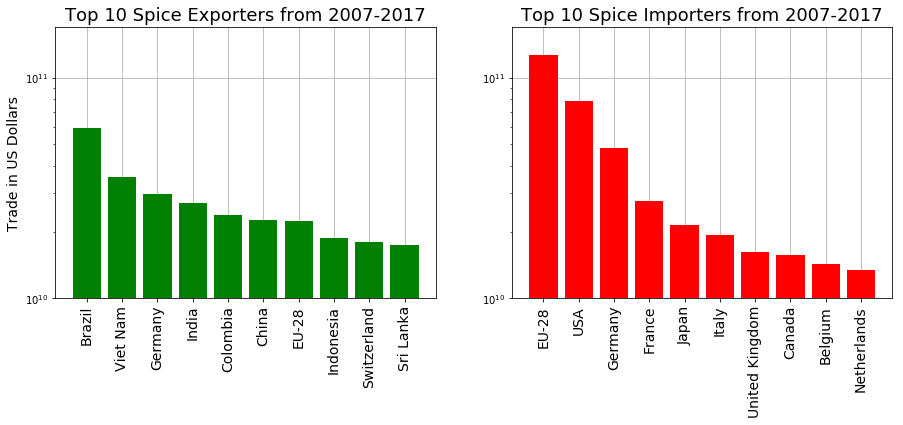

In [14]:
# Cumulative exports by country between 2007-2017 & top ten list
cnty_ex = exports.groupby('country')['USD'].sum()
cnty_topex = cnty_ex.nlargest(10, 'first')

# Cumulative imports by country between 2007-2017 & top ten list
cnty_im = imports.groupby('country')['USD'].sum()
cnty_topim = cnty_im.nlargest(10, 'first')

# Plot top 10 exporters & importers
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(cnty_topex.index, cnty_topex, log=True, zorder=10, color='g')
plt.title('Top 10 Spice Exporters from 2007-2017', fontsize=18)
plt.ylabel('Trade in US Dollars', fontsize=14)
plt.ylim(10**10, 10.5**11)
plt.xticks(rotation='vertical', fontsize=14)
plt.grid(zorder=0)

plt.subplot(1,2,2)
plt.bar(cnty_topim.index, cnty_topim, log=True, zorder=10, color='r')
plt.title('Top 10 Spice Importers from 2007-2017', fontsize=18)
plt.ylim(10**10, 10.5**11)
plt.xticks(rotation='vertical', fontsize=14)
plt.grid(zorder=0)
#plt.show()

The top 10 spice exporters from 2007-2017 is an eclectic mix of countries.  Some are well-developed, first-world countries (e.g. Germany, EU, Switzerland) and some are still-developing countriest (e.g. Sri Lanka, Colombia, Viet Nam).  This makes sense as spice cultivation is driven more by environmental factors like climate and soil conditions than industrial factors.  It's likely that the smaller countries have one or two dominant spice exports that may be endemic to the local conditions.  Perhaps the better-developed countries use their industrial prowess to make up for weaker environmental conditions and thus have a much broader suite of spice exports.

The top 10 spice importers are all well-developed countries with strong economies.  This intuitively makes sense as these countries have the purchasing power to buy large quantities and a large breadth of spices.  They are likely immersed in the global marketplace with spice tastes that go well beyond their own borders.  

This is a nice look at exports and imports individually, but every country exists within the global market and can export and import the full range of spices.  Let's see what the spice trade looks like at the country level by calculating each country's spice trade surplus/deficit.

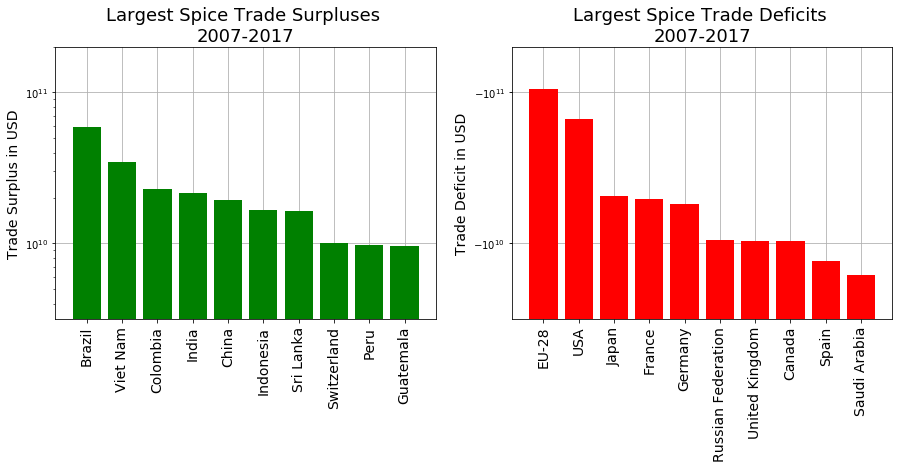

In [15]:
# Creating new DataFrame with exports and imports at the country level and adding a Trade Surplus column
cnty_trade = pd.DataFrame({'USDex': cnty_ex, 'USDim': cnty_im}).fillna(0)
cnty_trade['surplus'] = cnty_trade['USDex'] - cnty_trade['USDim']

# Creating series of largest surplus and deficit countries
tenbigsurp = cnty_trade['surplus'].nlargest(10)
tenbigdef = cnty_trade['surplus'].nsmallest(10)

# Plotting surplus & deficit countries
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.bar(tenbigsurp.index, tenbigsurp, color='g', zorder=10)
plt.title('Largest Spice Trade Surpluses \n2007-2017', fontsize=18)
plt.ylabel('Trade Surplus in USD', fontsize=14)
plt.yscale('log')
plt.ylim(10**9.5, 10**11.3)
plt.xticks(rotation='vertical', fontsize=14)
plt.grid(zorder=0)

plt.subplot(1,2,2)
plt.bar(tenbigdef.index, tenbigdef, color='r', zorder=10)
plt.title('Largest Spice Trade Deficits \n2007-2017', fontsize=18)
plt.ylabel('Trade Deficit in USD', fontsize=14)
plt.yscale('symlog')
plt.ylim(-10**9.5, -10**11.3)
plt.xticks(rotation='vertical', fontsize=14)
plt.grid(zorder=0)
plt.show()

The top 10 trade surplus list is little changed from the exporters list.  The few countries that dropped off were well-developed and were probably buying more spice than they were selling (e.g. the EU).  

Russia and Saudi Arabia both jumped onto the top ten deficit list.  Their climates are not conducive to spice production, but they do have strong economies which allows them to import significant quantities of spices.

This is a nice look at the top countries, but what does the entire global markteplace look like in terms of spice trade surpluses and deficits?

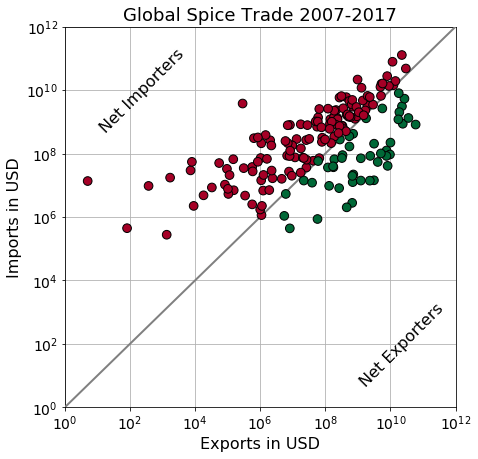

In [16]:
# Normalized colormap variable for plot
surplus = cnty_trade['surplus']
normalize = mpl.colors.Normalize(vmin=-1, vmax=1)

# Scatter plot of exports & imports for all countries
plt.figure(figsize=(7,7))
plt.scatter(cnty_trade['USDex'], 
            cnty_trade['USDim'], 
            zorder=10, 
            s=75, 
            edgecolors='k',
            c=surplus, 
            cmap='RdYlGn', 
            norm=normalize
           )
plt.plot((0,10**12), (0,10**12), c='gray', linewidth=2, zorder=5)
plt.title('Global Spice Trade 2007-2017', fontsize=18)
plt.xlabel('Exports in USD', fontsize=16)
plt.xscale('log')
plt.xticks(fontsize=14)
plt.xlim(1, 1000000000000)
plt.ylabel('Imports in USD', fontsize=16)
plt.yscale('log')
plt.yticks(fontsize=14)
plt.ylim(1, 1000000000000)
plt.text(10, 10**11, 'Net Importers', rotation=45, fontsize=16)
plt.text(10**9, 1000, 'Net Exporters', rotation=45, fontsize=16)
plt.grid(zorder=0)
plt.show()

From 2007-2017, most countries have imports and exports in excess of \$1 million US dollars and a majority over 100 million USD.  It also looks like many more countries are net spice importers than net spice exports.  Let's check that:

In [17]:
num_deficit = cnty_trade['surplus'][cnty_trade['surplus'] <= 0].count()
num_surplus = cnty_trade['surplus'][cnty_trade['surplus'] > 0].count()
print('{} countries have a cumulative spice trade surplus.'.format(num_surplus))
print('{} countries have a cumulative spice trade deficit.'.format(num_deficit))

48 countries have a cumulative spice trade surplus.
144 countries have a cumulative spice trade deficit.


Yup!  Three times more countries are net spice importers.  Again this makes sense because prominant spice growing regions are likely to be small and driven by environmental factors.  

Now that we've looked at the broader, global spice market, let's dive deeper into some country specific commodity trends.

### 2. What trends exist within individual country's spice trade?

We'll choose several countries from the lists above, find their top export or import commodities, and plot them by year.  First let's take a look at Brazil's exports and then we'll check out the EU's imports. 


In [18]:
# Brazil's top 5 spice export commodities
brazil_ex = exports[exports['country'] == 'Brazil'
                   ].groupby('commodity')['USD'].sum().sort_values(ascending=False)[:5]
brazil_ex

commodity
Coffee                                           5.602097e+10
Pepper of the genus Piper, whole                 2.170024e+09
Mate                                             7.809458e+08
Cloves (whole fruit, cloves and stems)           2.274372e+08
Capsicum or Pimenta, dried, crushed or ground    9.506406e+07
Name: USD, dtype: float64

Brazil's top spice export is coffee followed by whole pepper, mate, cloves, and chili powder.  Note that Brazil's cumulative coffee exports are 3 orders of magnitude larger than chili powder!

Now we'll look at the yearly trends of each of those spices.

In [19]:
# Creating a dict of shortened spice keys to pair with the full spice name found in the table.
cmdty_dict = dict(zip(list(cmdty_grouped.index),
                      ['anise',
                       'g_capsicum',
                       'caraway',
                       'cardamoms',
                       'g_cinnamon',
                       'w_cinnamon',
                       'cloves',
                       'coffee',
                       'coriander',
                       'cumin',
                       'curry',
                       'fenjun',
                       'ginger',
                       'mace',
                       'mate',
                       'spice_mix',
                       'nutmeg',
                       'g_pepper',
                       'w_pepper',
                       'saffron',
                       'spice_other',
                       'tea',
                       'thyme',
                       'tumeric',
                       'vanilla'
                      ]
                     )
                 )

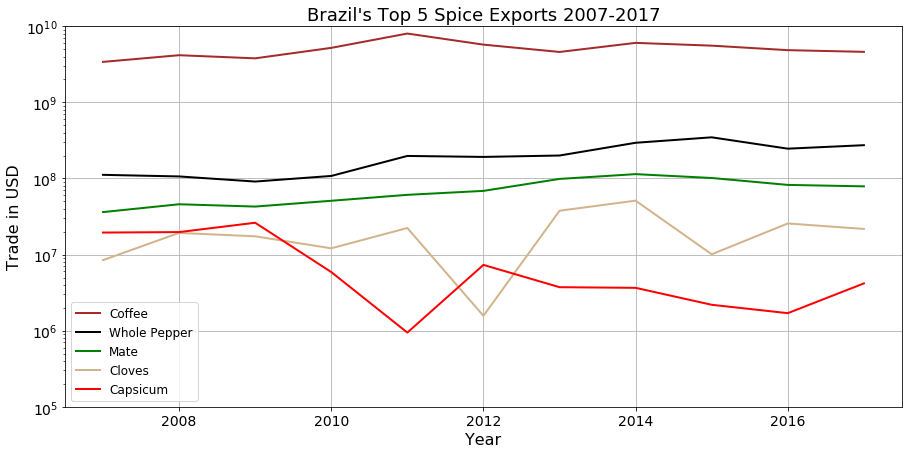

In [20]:
# Iterating through Brazil's top 5 exports and creating
# annual export dataframes for each spice, individually.

brazil_ex_df = exports[exports['country'] == 'Brazil']

var = []
bz_cmdty_dict = {}

for lg_spice in list(brazil_ex.index):
    # cmdty_dict coverts between the long and short commodity form
    var.append((str(cmdty_dict[lg_spice]), lg_spice))

for (sh_spice, lg_spice) in var:
    key = 'brazil_{}_ex'.format(sh_spice)
    sh_spice = pd.DataFrame(brazil_ex_df[brazil_ex_df['commodity'] == str(lg_spice)
                                        ].groupby(['country', 
                                                   'commodity', 
                                                   'year'
                                                  ])['USD'].sum().reset_index(drop=False)
                           )
    # Dict storing the specific spice data frame keyed to the shortened spice name
    bz_cmdty_dict[key] = sh_spice

# Annual trend plot of Brazil's top 5 spice exports
plt.figure(figsize=(15,7))
plt.plot(bz_cmdty_dict['brazil_coffee_ex'].iloc[:,2], bz_cmdty_dict['brazil_coffee_ex'].iloc[:,3], 
         linewidth=2, color='brown')
plt.plot(bz_cmdty_dict['brazil_w_pepper_ex'].iloc[:,2], bz_cmdty_dict['brazil_w_pepper_ex'].iloc[:,3], 
         linewidth=2, color='k')
plt.plot(bz_cmdty_dict['brazil_mate_ex'].iloc[:,2], bz_cmdty_dict['brazil_mate_ex'].iloc[:,3], 
         linewidth=2, color='g')
plt.plot(bz_cmdty_dict['brazil_cloves_ex'].iloc[:,2], bz_cmdty_dict['brazil_cloves_ex'].iloc[:,3], 
         linewidth=2, color='tan')
plt.plot(bz_cmdty_dict['brazil_g_capsicum_ex'].iloc[:,2], bz_cmdty_dict['brazil_g_capsicum_ex'].iloc[:,3], 
         linewidth=2, color='red')
plt.title("Brazil's Top 5 Spice Exports 2007-2017", fontsize=18)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Trade in USD', fontsize=16)
plt.yscale('log')
plt.ylim(10**5,10**10)
plt.yticks(fontsize=14)
plt.legend(('Coffee', 'Whole Pepper', 'Mate', 'Cloves', 'Capsicum'), fontsize=12, loc='best')
plt.grid()
plt.show()

Here are the annual trends of Brazil's top 5 spice exports. **Note the log scale on the Y-axis!** This significantly impairs one's ability to vizualize the percent annual change, however, it does allow us to see all the data on one plot.

Coffee is definitely the main export raking in over \$3 billion annually, but there are at least four exports which cleared 1 million USD annually. Coffee exports more than doubled from 2007-2011 and then declined.  Over the decade, coffee exports have stayed flat.  Pepper and mate exports have both just about doubled since 2007.  Capsicum and cloves both had sharp year-over-year falls of over 90\% in 2011 and 2012, respectively. Clove exports quickly rebounded and ended the decade up nearly 50\%.  However, capsicum didn't fare well after the export decline and had depressed output for the remainder of the timeframe.

While we can't be certain without much more data, the juxtaposition of the clove and capsicum export trends is interesting.  It seems like we see a different market factor at play for each. Perhaps in 2012 the clove crop was irrevocably damaged by insects or a natural disaster like a flood or fire -- something that would inflict short-term pain, but not affect the long-term market conditions.  Conversely, the capsicum exports were likely harmed by an external change to the market such as tarifs which would reset the long-term market to a different operating level.

Now let's take a look at the EU's spice imports.

In [21]:
# EU's top 5 spice imports
eu_im = imports[imports['country'] == 'EU-28'
               ].groupby('commodity')['USD'].sum().sort_values(ascending=False)[:5]
eu_im

commodity
Coffee                                           1.053663e+11
Tea                                              9.005334e+09
Pepper of the genus Piper, whole                 3.732060e+09
Capsicum or Pimenta, dried, crushed or ground    2.082344e+09
Vanilla beans                                    1.248896e+09
Name: USD, dtype: float64

More than 10 times more coffee than tea has been imported into the EU from 2007 to 2017.  Let's see what the annual trends look like.

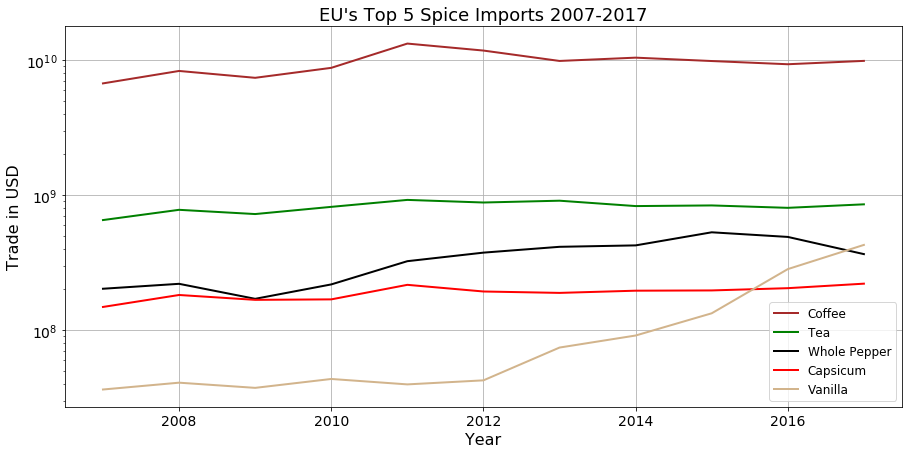

In [22]:
# Iterating through EU's top 5 imports and creating
# annual import dataframes for each individually

eu_im_df = imports[imports['country'] == 'EU-28']

var = []
for lg_spice in list(eu_im.index):
    # cmdty_dict coverts between the long and short commodity form
    var.append((str(cmdty_dict[lg_spice]), lg_spice))

eu_cmdty_dict = {}
for (sh_spice, lg_spice) in var:
    key = 'eu_{}_im'.format(sh_spice)
    sh_spice = pd.DataFrame(eu_im_df[eu_im_df['commodity'] == str(lg_spice)
                                        ].groupby(['country', 
                                                   'commodity', 
                                                   'year'
                                                  ])['USD'].sum().reset_index(drop=False)
                           )
    eu_cmdty_dict[key] = sh_spice


plt.figure(figsize=(15,7))
plt.plot(eu_cmdty_dict['eu_coffee_im'].iloc[:,2], eu_cmdty_dict['eu_coffee_im'].iloc[:,3], 
         linewidth=2, color='brown')
plt.plot(eu_cmdty_dict['eu_tea_im'].iloc[:,2], eu_cmdty_dict['eu_tea_im'].iloc[:,3], 
         linewidth=2, color='green')
plt.plot(eu_cmdty_dict['eu_w_pepper_im'].iloc[:,2], eu_cmdty_dict['eu_w_pepper_im'].iloc[:,3], 
         linewidth=2, color='k')
plt.plot(eu_cmdty_dict['eu_g_capsicum_im'].iloc[:,2], eu_cmdty_dict['eu_g_capsicum_im'].iloc[:,3], 
         linewidth=2, color='r')
plt.plot(eu_cmdty_dict['eu_vanilla_im'].iloc[:,2], eu_cmdty_dict['eu_vanilla_im'].iloc[:,3], 
         linewidth=2, color='tan')
plt.title("EU's Top 5 Spice Imports 2007-2017", fontsize=18)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Trade in USD', fontsize=16)
plt.yscale('log')
plt.yticks(fontsize=14)
plt.legend(('Coffee', 'Tea', 'Whole Pepper', 'Capsicum', 'Vanilla'), fontsize=12, loc='best')
plt.grid()
plt.show()

Compared to Brazil's exports, the EU's top 5 spice imports have remained relatively flat (though do keep that log scale in mind!). The exeptions being pepper and vanillia.  Pepper imports roughly doubled from 2009 to 2015 before declining, while vanilla imports have grown substantially, ending the timeframe nearly 10 times higher than 2007.

It is important to note that an underlying assumption of this interpretation is a constant commodity price.  As mentioned and linked to in the intro, vanilla has become more expensive than silver in the last several years.  So, perhaps its more likely that the EU's imports of vanilla have not grown substantially (or maybe they've even decreased!) and that the skyrocketing price of vanilla has caused the EU to pay more for the vanilla it imports.

Let's plot up the EU's vanilla imports again, this time by mass, to get a clearer sense of the EU's vanilla market.

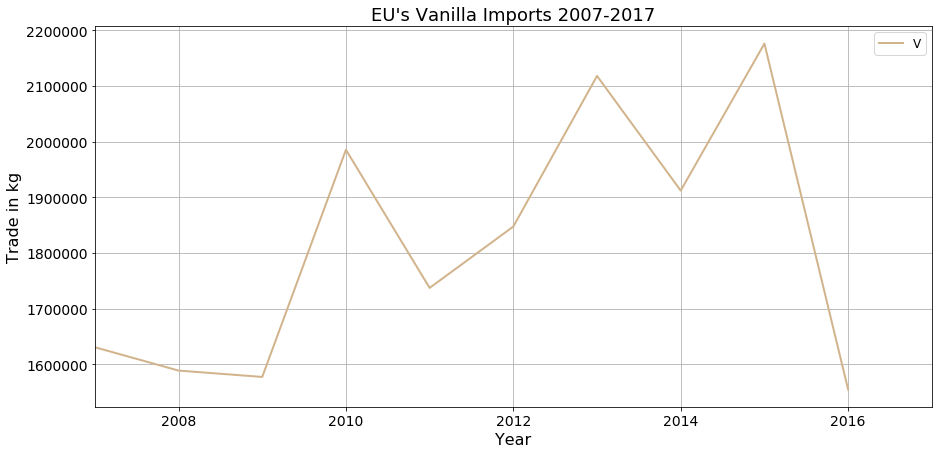

In [23]:
eu_vanilla_im_kg = pd.DataFrame(eu_im_df[eu_im_df['commodity'] == 'Vanilla beans'
                                        ].groupby(['country', 
                                                   'commodity', 
                                                   'year'
                                                  ])['kg'].sum().reset_index(drop=False)
                               )

# No data present for EU vanilla imports in 2017, reseting 0 to NaN
eu_vanilla_im_kg.iloc[-1,[-1]] = np.nan

# Plot of EU vanilla imports by kg
plt.figure(figsize=(15,7))
plt.plot(eu_vanilla_im_kg['year'], eu_vanilla_im_kg['kg'], linewidth=2, color='tan')
plt.title("EU's Vanilla Imports 2007-2017", fontsize=18)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14)
plt.xlim(2007,2017)
plt.ylabel('Trade in kg', fontsize=16)
#plt.yscale('log')
plt.yticks(fontsize=14)
plt.legend('Vanilla', fontsize=12, loc='best')
plt.grid()
plt.show()

**Note this plot has a linear Y-axis, not log like we've seen previously!**

Now it's clear that the EU actually did increase it's vanilla imports by ~33\% from 2009 to 2015 before immediately reversing those gains in 2016.  Perhaps, the increasing vanilla price finally struck a nerve in 2016 and drastically changed the EU market behavior.

These import changes are minor compared to the difference we saw above when tracking the EU's purchase price for all it's vanilla.  Remember that they were paying 10 times more in 2017 than in 2007, all because of several typhoons in Madagascar.

While the vanilla market dynamics have been covered in great detail in the media, we can explore this concept of a single country's influence on a spice commodity market in more detail for the other spices.



### 3. Which countries have captured significant market share for a particular spice?

Essentially what we're asking here is to identify countries which are significant outliers in the cumulative export of a given spice.  First we'll look at the distribution of cumulative exports to see if they are normal. Then we'll discuss and calculate several potential measures of "outlier-ness". Finally, we'll use those to attempt to identify several countries which dominate a particular spice market.


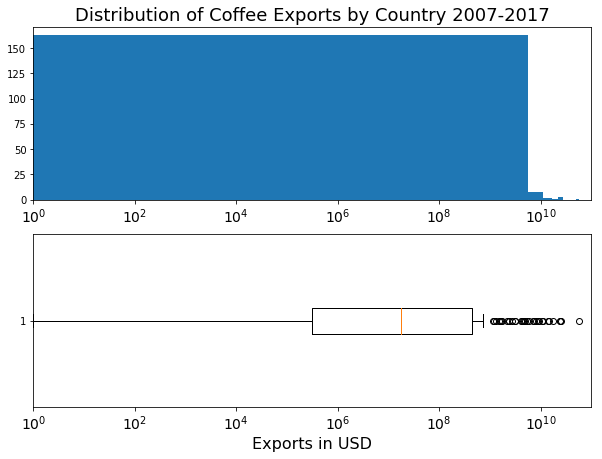

In [24]:
# Cumulative exports of a commodity from a given country
cmdty_ex = exports.groupby(['commodity', 'country'])['USD'].sum()

# All coffee exports
cf_ex = pd.DataFrame(cmdty_ex).query("commodity == 'Coffee'")

# Distribution plots of coffee export data
plt.figure(figsize=(10,7))

plt.subplot(2,1,1)
plt.hist(cf_ex['USD'], histtype='stepfilled')
plt.title('Distribution of Coffee Exports by Country 2007-2017', fontsize=18)
plt.xscale('log')
plt.xlim(1, 10**11)
plt.xticks(fontsize=14)

plt.subplot(2,1,2)
plt.boxplot(cf_ex['USD'], vert=False)
plt.xlabel('Exports in USD', fontsize=16)
plt.xscale('log')
plt.xlim(1, 10**11)
plt.xticks(fontsize=14)
plt.show()

Here are two different visualizations of the country level cumulative coffee exports. Both the histogram and box plot make it abundantly clear that the distribution is not normal.  This is unfortunate because it means we can't use any typical statistical measures of "outlier-ness". We'll have to wing it.

Let's try two different options. The first will basically measure how far the top exporting country is away from the mean.  The second will measure the separation between the top and the second exporting country.

In [25]:
# Top and mean exporter of a given commodity
top_cmdty_ex = pd.DataFrame(cmdty_ex.groupby(level='commodity').max())
mean_cmdty_ex = pd.DataFrame(cmdty_ex.groupby(level='commodity').mean())

top_cmdty_ex = pd.merge(top_cmdty_ex, mean_cmdty_ex, how='inner', on='commodity')
top_cmdty_ex.columns = ['max_USD', 'mean_USD']
top_cmdty_ex['max_times_past_mean'] = (top_cmdty_ex['max_USD'] - top_cmdty_ex['mean_USD']) / top_cmdty_ex['mean_USD']
top_cmdty_ex = top_cmdty_ex.sort_values('max_times_past_mean', ascending=False)
top_cmdty_ex[:5]

,max_USD,mean_USD,max_times_past_mean
commodity,,,
Turmeric (curcuma),1.336262e+09,1.397709e+07,94.603749
Ginger,3.947513e+09,4.564830e+07,85.476679
Cumin seeds,2.229444e+09,2.900613e+07,75.861145
Cardamoms,2.386068e+09,3.530345e+07,66.587401
Vanilla beans,1.671455e+09,2.803240e+07,58.625803


To get at "distance from mean" we calculated how many times past the mean the maximum value lies. As evidenced in the code above that is `(max - mean) / mean`. Remember that we can't use a typical measure like standard deviation, because this data is not normal.

It's nice to see vanilla on this list given what we've discussed previously, but apparently Madagascar's vanilla market dominance is far surpassed by the top exporters of turmeric, ginger, cumin, and cardamom.

Now lets measure the gap between the first two exporters.

In [26]:
# Creates a series with the top 2 largest exporters for each spice
top_two_cntry = cmdty_ex.groupby(level='commodity').nlargest(2).reset_index(level=0, drop=True).reset_index()

# Calculates the gap between the top and second exporter for each spice
max_minus_second = []
for i in range(0, len(top_two_cntry), 2):
    max_gap = top_two_cntry.iat[i, 2] - top_two_cntry.iat[i+1, 2]
    max_minus_second.append((top_two_cntry.iat[i, 0], max_gap))

gap_to_sec = pd.DataFrame(max_minus_second)
gap_to_sec.columns = ['commodity', 'gap_sec']
gap_to_sec = gap_to_sec.set_index('commodity').sort_values(by='gap_sec', ascending=False)
gap_to_sec[:7]

,gap_sec
commodity,
Coffee,3.078380e+10
"Pepper of the genus Piper, whole",3.506685e+09
Ginger,3.399460e+09
Tea,3.142910e+09
"Capsicum or Pimenta, dried, crushed or ground",1.956427e+09
Cumin seeds,1.938892e+09
Cardamoms,1.754821e+09


Here is the list of the spices with the largest gap between the top and second exporter.  There are 7 listed because I'm inclined to disregard the coffee and tea categories since we initially combined several subsets.  This gap is an absolute measure, but difficult to compare across commodities given that market sizes vary by several orders of magnitude.  Let's make this gap relative to the "mean exporter".

In [27]:
top_cmdty_ex = top_cmdty_ex.sort_index()
gap_to_sec = gap_to_sec.sort_index()

outlier_comp = pd.merge(top_cmdty_ex, gap_to_sec, how='outer', on='commodity')

outlier_comp['gap_sec_means'] = outlier_comp['gap_sec'] / outlier_comp['mean_USD']

# Ranking the two different measures of outliers
outlier_comp['max_times_rank'] = outlier_comp['max_times_past_mean'].rank(ascending=True)
outlier_comp['gap_rank'] = outlier_comp['gap_sec_means'].rank(ascending=True)
outlier_comp['total_rank'] = outlier_comp['max_times_rank'] + outlier_comp['gap_rank']
outlier_comp.sort_values('total_rank', ascending=False)[:5]

,max_USD,mean_USD,max_times_past_mean,gap_sec,gap_sec_means,max_times_rank,gap_rank,total_rank
commodity,,,,,,,,
Turmeric (curcuma),1.336262e+09,1.397709e+07,94.603749,1.249174e+09,89.372929,25.0,25.0,50.0
Ginger,3.947513e+09,4.564830e+07,85.476679,3.399460e+09,74.470679,24.0,24.0,48.0
Cumin seeds,2.229444e+09,2.900613e+07,75.861145,1.938892e+09,66.844231,23.0,23.0,46.0
Cardamoms,2.386068e+09,3.530345e+07,66.587401,1.754821e+09,49.706787,22.0,22.0,44.0
Vanilla beans,1.671455e+09,2.803240e+07,58.625803,1.363074e+09,48.624932,21.0,21.0,42.0


Ok, so it turns out that both of our measures of "outlier-ness" created the same list of spices. Let's plot this up to visually confirm.

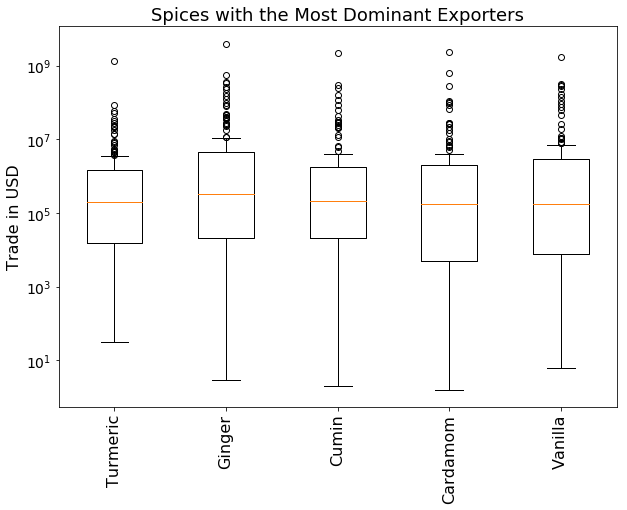

In [28]:
# Cumulative exports of spices with the most dominant exporters
turmeric_ex = pd.DataFrame(cmdty_ex).query("commodity == 'Turmeric (curcuma)'")
ginger_ex = pd.DataFrame(cmdty_ex).query("commodity == 'Ginger'")
cumin_ex = pd.DataFrame(cmdty_ex).query("commodity == 'Cumin seeds'")
cardamom_ex = pd.DataFrame(cmdty_ex).query("commodity == 'Cardamoms'")
vanilla_ex = pd.DataFrame(cmdty_ex).query("commodity == 'Vanilla beans'")

plt.figure(figsize=(10,7))
plt.boxplot((turmeric_ex['USD'], 
             ginger_ex['USD'], 
             cumin_ex['USD'], 
             cardamom_ex['USD'], 
             vanilla_ex['USD']
            )
           )
plt.title('Spices with the Most Dominant Exporters', fontsize=18)
plt.ylabel('Trade in USD', fontsize=16)
plt.yscale('log')
plt.yticks(fontsize=14)
plt.xticks([1, 2, 3, 4, 5], 
           ['Turmeric', 'Ginger', 'Cumin', 'Cardamom', 'Vanilla'], 
           rotation='vertical',
           fontsize=16)
plt.show()

The boxplots confirm the large gaps between the top exporters and second place as well as a significant gap between the top exporter and the mean exporter.  Which countries control the turmeric, ginger, cumin, cardamom, and vanilla markets?

In [29]:
turmeric_ex = turmeric_ex.sort_values('USD', ascending=False).reset_index(drop=False)
top_turmeric = turmeric_ex.at[0, 'country']

ginger_ex = ginger_ex.sort_values('USD', ascending=False).reset_index(drop=False)
top_ginger = ginger_ex.at[0, 'country']

cumin_ex = cumin_ex.sort_values('USD', ascending=False).reset_index(drop=False)
top_cumin = cumin_ex.at[0, 'country']

cardamom_ex = cardamom_ex.sort_values('USD', ascending=False).reset_index(drop=False)
top_cardamom = cardamom_ex.at[0, 'country']

vanilla_ex = vanilla_ex.sort_values('USD', ascending=False).reset_index(drop=False)
top_vanilla = vanilla_ex.at[0, 'country']

print('The top tumeric exporter is {}.'.format(top_turmeric))
print('The top ginger exporter is {}.'.format(top_ginger))
print('The top cumin exporter is {}.'.format(top_cumin))
print('The top cardamom exporter is {}.'.format(top_cardamom))
print('The top vanilla exporter is {}.'.format(top_vanilla))

The top tumeric exporter is India.
The top ginger exporter is China.
The top cumin exporter is India.
The top cardamom exporter is Guatemala.
The top vanilla exporter is Madagascar.


Cool! These represent our best guesses for monopolistic spice markets. Obviously, the vanilla market was completely upended by several typhoons hitting Madagascar.  Its unlikely that a similar event could disrupt the turmeric and cumin business in India or the ginger market in China.  But, if you ever hear about a significant weather or government event happening in Guatemala, be sure to stock up on cardamom!

That wraps up our analysis of the global spice trade from 2007 to 2017.  We've only scratched the surface of what can be done with the data and I'll leave you a set of potential directions to take future analyses.

### Future analyses and questions
1. Re-run the analysis with the full spectrum of coffee and tea commodity types.
    - I did this during my initial exploration but ultimately decided to combine them for the full analysis for simplicity.
    - Could look at how the each sub-category's market share of the broader coffee/tea market changes over time.
2. Re-run the analysis using the full set of UN data dating back to 1992.
3. Explore commodities with most change, annually or over the whole timeframe.
    - What spices have gotten the most popular over the timeframe?
4. Track the market price for each spice using USD/kg.
    - What are the cheapest and most expensive spices, annually or over the whole timeframe
5. Track a country's surplus/deficit over the timeframe.